In [1]:
!pip install BERTopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.3 MB/s eta 0:00:00


In [58]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from math import ceil, sqrt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import json
from difflib import SequenceMatcher
import unicodedata

In [59]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = 	BERTopic.load("Israel_Hamas_ControversialComments_model", embedding_model=embedding_model)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
topics = topic_model.get_topics()
topics_words = {}

for topic_num, words in topics.items():
    words = [word.lower() for word, prob in words]
    for word in words:
        if word in topics_words:
            topics_words[word] += 1
        else:
            topics_words[word] = 1

In [ ]:
topics_words = dict(sorted(topics_words.items(), key=lambda x: x[1], reverse=True))
topics_words = {word:count for word, count in topics_words.items() if word!=''}

In [ ]:
words = list(topics_words.keys())
counts = list(topics_words.values())

In [ ]:
# Define keywords for Israel and Hamas
israel_keywords = [
    "Likud", "Neturei Karta", "Six-Day War", "Jewish", "ethnic cleansing", "West Bank", "Zion",
    "Balfour Declaration", "apartheid", "Jews", "aliyah", "Jerusalem", "Torah", "Palestine",
    "Edah HaChareidis", "Satmar", "colonialism", "religious ideology", "National Religious Party",
    "Anti-Defamation League", "Yasser Arafat", "Arthur Balfour", "Theodor Herzl", "Abba Eban",
    "kibbutzim", "Gush Emunim", "national liberation movements", "Holocaust", "Double standards",
    "Chaim Herzog", "Online hate speech", "anti-Semitic stereotypes", "UN General Assembly Resolution 46/86",
    "homeland", "Benjamin Netanyahu", "Daniel Patrick Moynihan", "Levant", "Eliezer Ben-Yehuda",
    "antisemitic", "genocide", "pogrom", "forced conversion", "Ku Klux Klan", "persecution", "neo-Nazi",
    "blood libel", "synagogue destruction", "racism", "Martin Luther"
]

hamas_keywords = [
    "genocide", "Palestinian", "Second Intifada", "First Intifada", "Jerusalem", "Palestine",
    "self-determination", "war crimes", "Balfour Declaration", "Al-Aqsa Mosque", "Jewish",
    "International Solidarity Movement", "ethnic cleansing", "antisemitism", "Mahmoud Abbas",
    "apartheid", "Benjamin Netanyahu", "free speech", "Jordan River", "human rights",
    "antisemitic", "Arab League", "BDS movement", "Six-Day War", "occupation",
    "one-state solution", "right of return", "Anti-Defamation League", "Tel Aviv",
    "Holocaust survivors", "Amnesty International", "Jews", "terrorism", "UN General Assembly",
    "peace process", "Elbit Systems", "International Day of Solidarity", "Oslo Accords",
    "Bethlehem", "Antony Blinken", "Arafat", "Al-Aqsa clashes", "Hebron", "Islamophobia",
    "fear of Islam", "Islamophobic", "discrimination", "discriminatory practices", "terrorism",
    "terrorist attacks", "September 11", "prejudice against Islam", "violent Islam", "Islamist",
    "racism", "multiculturalism", "barbaric", "monolithic bloc", "Islamic", "fundamentalism",
    "Islamophilia", "CAIR", "xenophobia", "Sharia law", "Islam Awareness Week",
    "English Defence League", "sexist", "primitive", "clash of civilizations", "hijab", "9/11",
    "physical attacks", "Charlie Hebdo", "random assaults", "potential terrorists", "Muslim",
    "oppression", "extermination", "Christchurch mosque shootings", "critical race theory",
    "identity politics", "war on terror", "Orientalism", "surveillance of mosques", "Death to Arabs",
    "anti-semitism", "hate crime", "media portrayals"
]

In [ ]:
# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

# Load sentiment analyzer
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Helper function to compute BERT embeddings
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=32)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze()

# Precompute embeddings for keywords
def compute_keyword_embeddings(keywords):
    embeddings = {}
    for keyword in keywords:
        embeddings[keyword] = get_embeddings(keyword)
    return embeddings

israel_embeddings = compute_keyword_embeddings(israel_keywords)
hamas_embeddings = compute_keyword_embeddings(hamas_keywords)

# Function to predict category and sentiment
def predict_category_and_sentiment(text):
    text_embedding = get_embeddings(text)

    # Compute similarity with Israel keywords
    israel_scores = [
        cosine_similarity(text_embedding.unsqueeze(0).numpy(), embed.unsqueeze(0).numpy())[0][0]
        for embed in israel_embeddings.values()
    ]

    # Compute similarity with Hamas keywords
    hamas_scores = [
        cosine_similarity(text_embedding.unsqueeze(0).numpy(), embed.unsqueeze(0).numpy())[0][0]
        for embed in hamas_embeddings.values()
    ]

    # Determine category
    israel_similarity = np.mean(israel_scores)
    hamas_similarity = np.mean(hamas_scores)

    similarity = 0.0

    if israel_similarity > hamas_similarity:
        category = "Israel"
        similarity = israel_similarity
    elif hamas_similarity > israel_similarity:
        category = "Hamas"
        similarity = hamas_similarity
    else:
        category = "Neutral"

    # Predict sentiment
    sentiment_result = sentiment_analyzer(text)[0]
    sentiment = sentiment_result['label']

    return category, similarity, sentiment, sentiment_result['score']

In [ ]:
# Initialize categories
categories = {
    "Pro-Israel": [],
    "Pro-Hamas": [],
    "Anti-Israel": [],
    "Anti-Hamas": [],
    "Neutral": []
}


In [ ]:
# Function to analyze sentiment and categorize
def categorize_word(word):
  try:
    # Perform sentiment analysis
    category, similarity, sentiment, score = predict_category_and_sentiment(word)
    # Assign to a category based on sentiment and context
    if category == 'Israel':
      if sentiment == "POSITIVE":
        categories["Pro-Israel"].append((word, similarity, score))
      elif sentiment == "NEGATIVE":
        categories["Anti-Israel"].append((word, similarity, score))
    elif category == 'Hamas':
      if sentiment == "POSITIVE":
        categories["Pro-Hamas"].append((word, similarity, score))
      elif sentiment == "NEGATIVE":
        categories["Anti-Hamas"].append((word, similarity, score))
    else:
      categories["Neutral"].append((word, similarity, score))
  except Exception as e:
    print(f"Error processing word {word}: {e}")
    categories["Neutral"].append((word, 0, 0))

In [ ]:
for word in words:
  categorize_word(word)

In [ ]:
import json
formatted_categories = {
    category: [
        {
            "word": item[0],
            "category_score": round(float(item[1]), 5),
            "sentiment_score": round(float(item[2]), 5)
        }
        for item in values
    ]
    for category, values in categories.items()
}

with open("categories_israel_hamas.json", "w") as file:
    json.dump(formatted_categories, file, indent=4)

print("Dictionary saved to categories_israel_hamas.json!")

Dictionary saved to categories_israel_hamas.json!


In [20]:
def read_json_file(file_path):
  try:
    with open(file_path, 'r') as file:
      data = json.load(file)
    return data
  except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    return None
  except json.JSONDecodeError:
    print(f"Error: Invalid JSON format in {file_path}")
    return None

# Example usage:
file_path = "categories_israel_hamas.json"  # Replace with your file path
categories = dict(read_json_file(file_path))


In [21]:
temp = {
    "Pro-Israel": [],
    "Pro-Hamas": [],
    "Anti-Israel": [],
    "Anti-Hamas": [],
    "Neutral": []
}
for key in categories.keys():
  for data in categories[key]:
    temp[key].append([data["word"],data["category_score"],data['sentiment_score']])

categories = temp

In [46]:
def remove_diacritics(word):
    nfkd_form = unicodedata.normalize('NFKD', word)
    return ''.join([char for char in nfkd_form if not unicodedata.combining(char)])

def are_similar(word1, word2, threshold=0.8):
    return SequenceMatcher(None, word1, word2).ratio() >= threshold

def cluster_words(words, threshold=0.8):
    clusters = []
    for word in words:
        for cluster in clusters:
            if are_similar(word, cluster[0], threshold):
                cluster.append(word)
                break
        else:
            clusters.append([word])
    return clusters

def normalize_to_representative(clusters):
    return {word: min(cluster, key=len) for cluster in clusters for word in cluster}

def normalize_data(words):
  words = [remove_diacritics(word).lower() for word in words]
  clusters = cluster_words(words)
  normalized_mapping = normalize_to_representative(clusters)
  return [normalized_mapping[word] for word in words]

In [55]:
temp = {
    "Pro-Israel": [],
    "Pro-Hamas": [],
    "Anti-Israel": [],
    "Anti-Hamas": [],
    "Neutral": []
}
for key in categories.keys():
  org_words = [i for i,j,k in categories[key]]
  normalized_words = normalize_data(org_words)
  for data in categories[key]:
    if(data[0] in normalized_words):
      temp[key].append([data[0],data[1],data[2]])
    else:
      index = org_words.index(data[0])
      word = normalized_words[index]
      temp[key].append([word ,data[1],data[2]])

  df = pd.DataFrame(temp[key], columns=['Group', 'Value1', 'Value2'])
  aggregated_data = df.groupby('Group').mean().reset_index()
  temp[key] = aggregated_data.values.tolist()

categories = temp

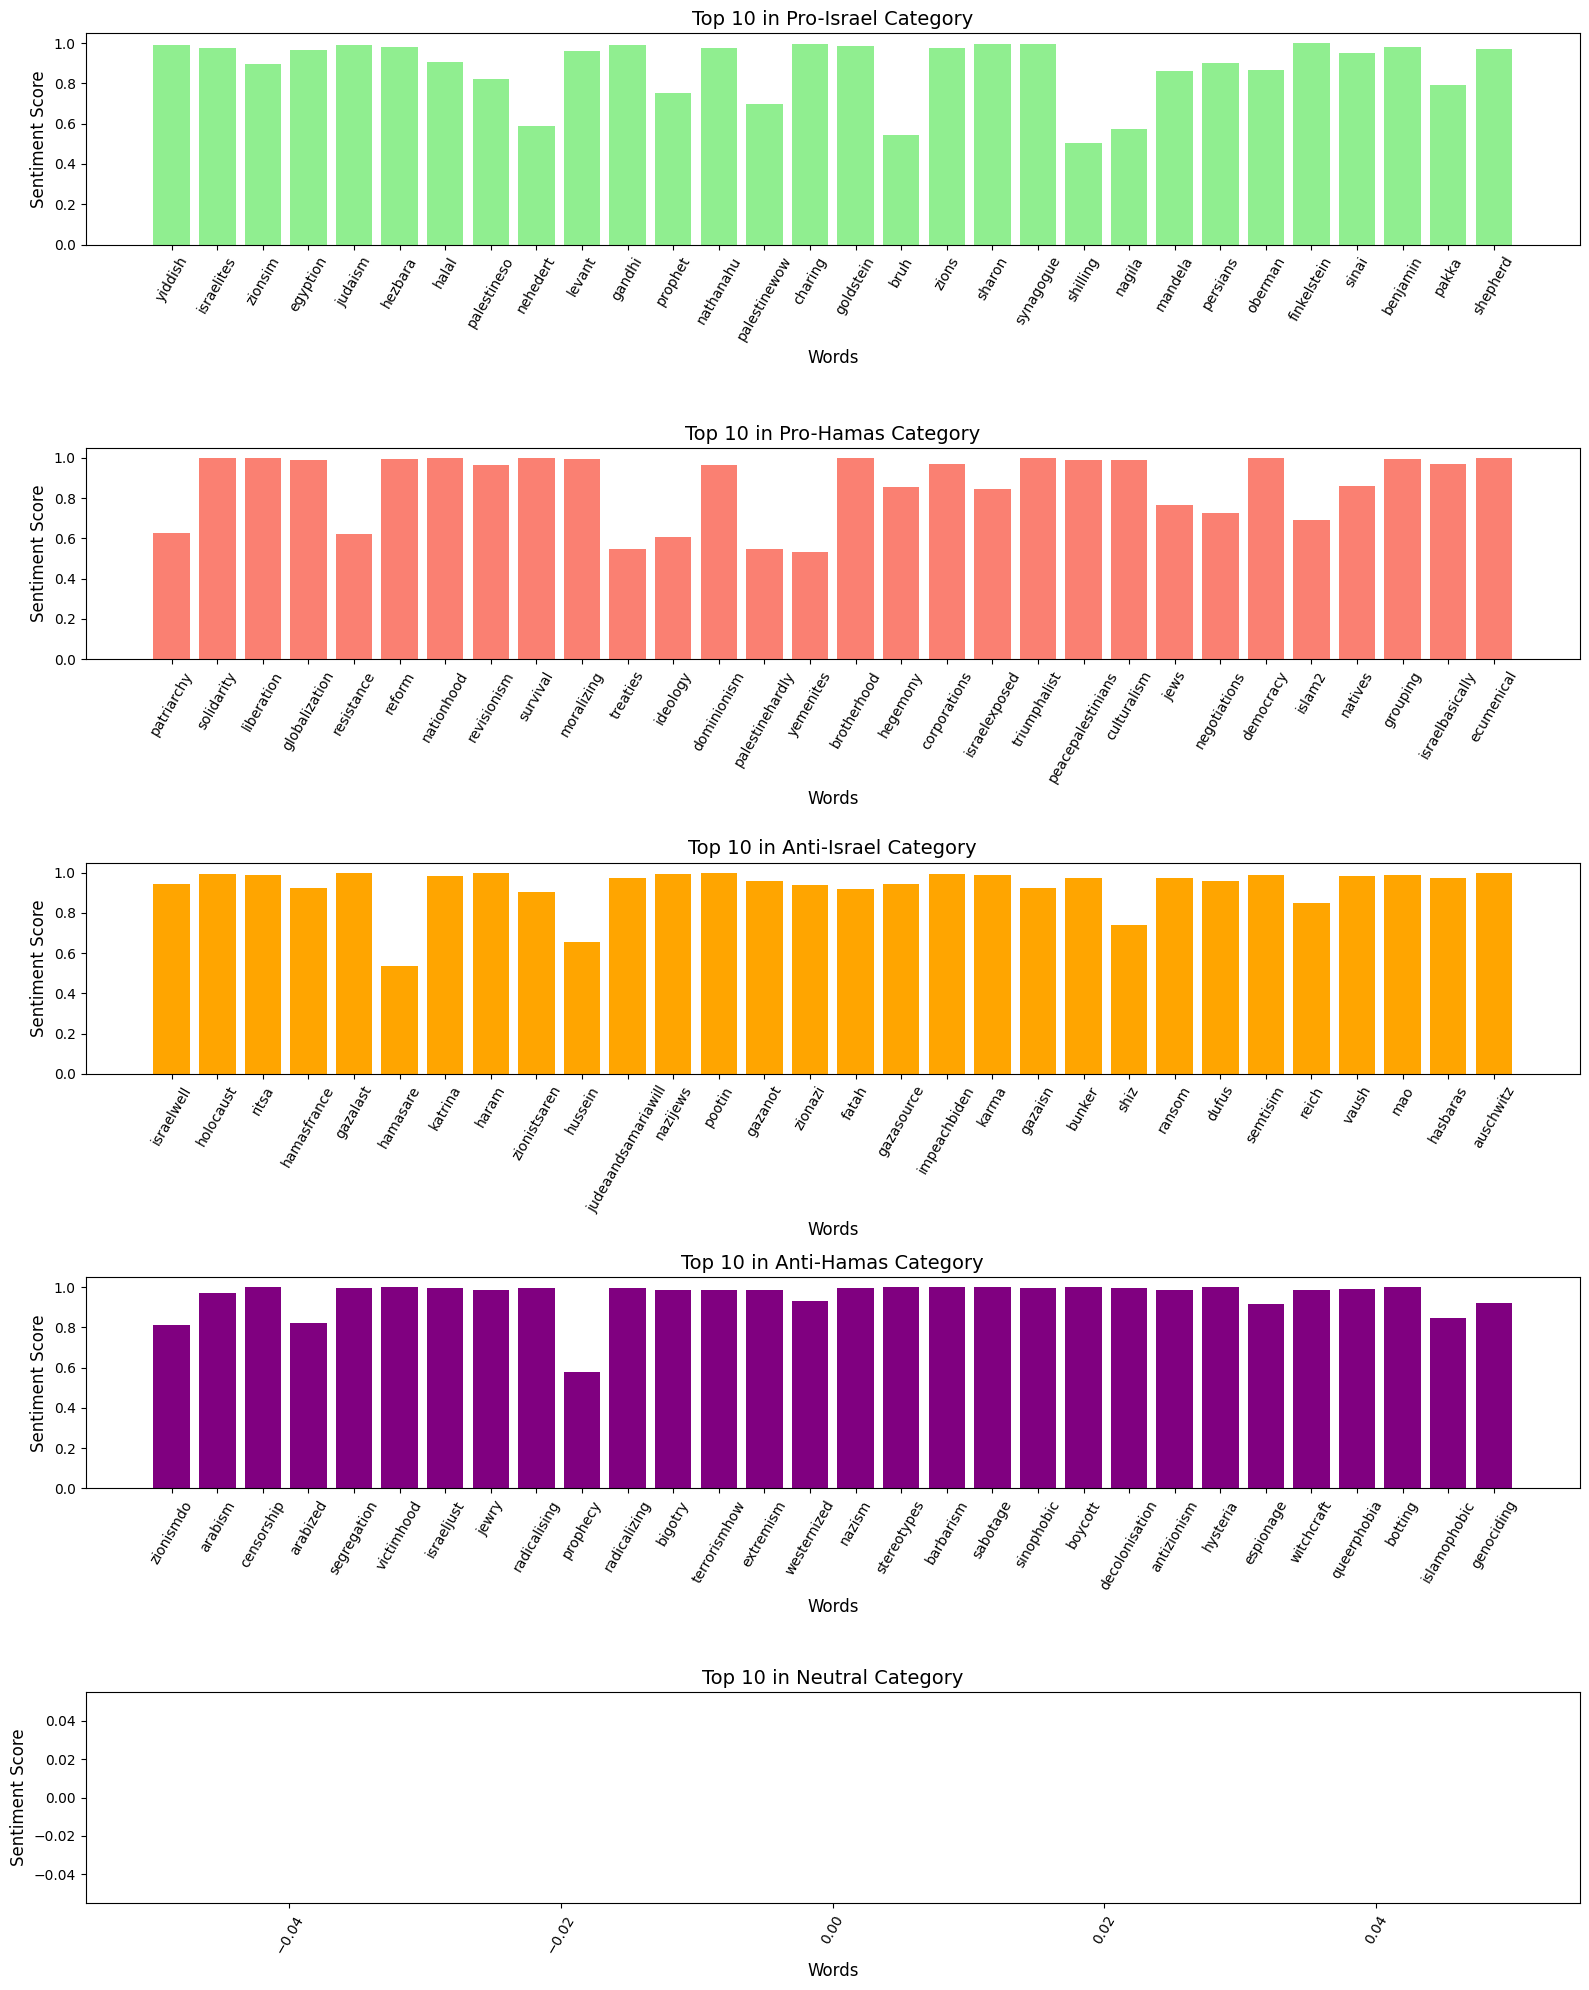

In [56]:
colors = ["skyblue", "lightgreen", "salmon", "orange", "purple", "teal"]  # Custom colors for bars

plt.figure(figsize=(16, 20))  # Adjust figure size for clarity
i = 0

# Loop through each category to create subplots
for category, words in categories.items():
    # Sort words by sentiment score in descending order
    flag = sorted(words, key=lambda x: (x[1], x[2]), reverse=True)
    top_words = [word for word, similarity, score in flag[:30]]  # Top 30 words
    top_scores = [score for word, similarity, score in flag[:30]]  # Corresponding scores

    plt.subplot(5, 1, i + 1)
    i += 1
    plt.bar(top_words, top_scores, color=colors[i % len(colors)])
    plt.xticks(rotation=60, fontsize=10)
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Sentiment Score", fontsize=12)
    plt.title(f"Top 10 in {category} Category", fontsize=14)

plt.tight_layout()
plt.show()

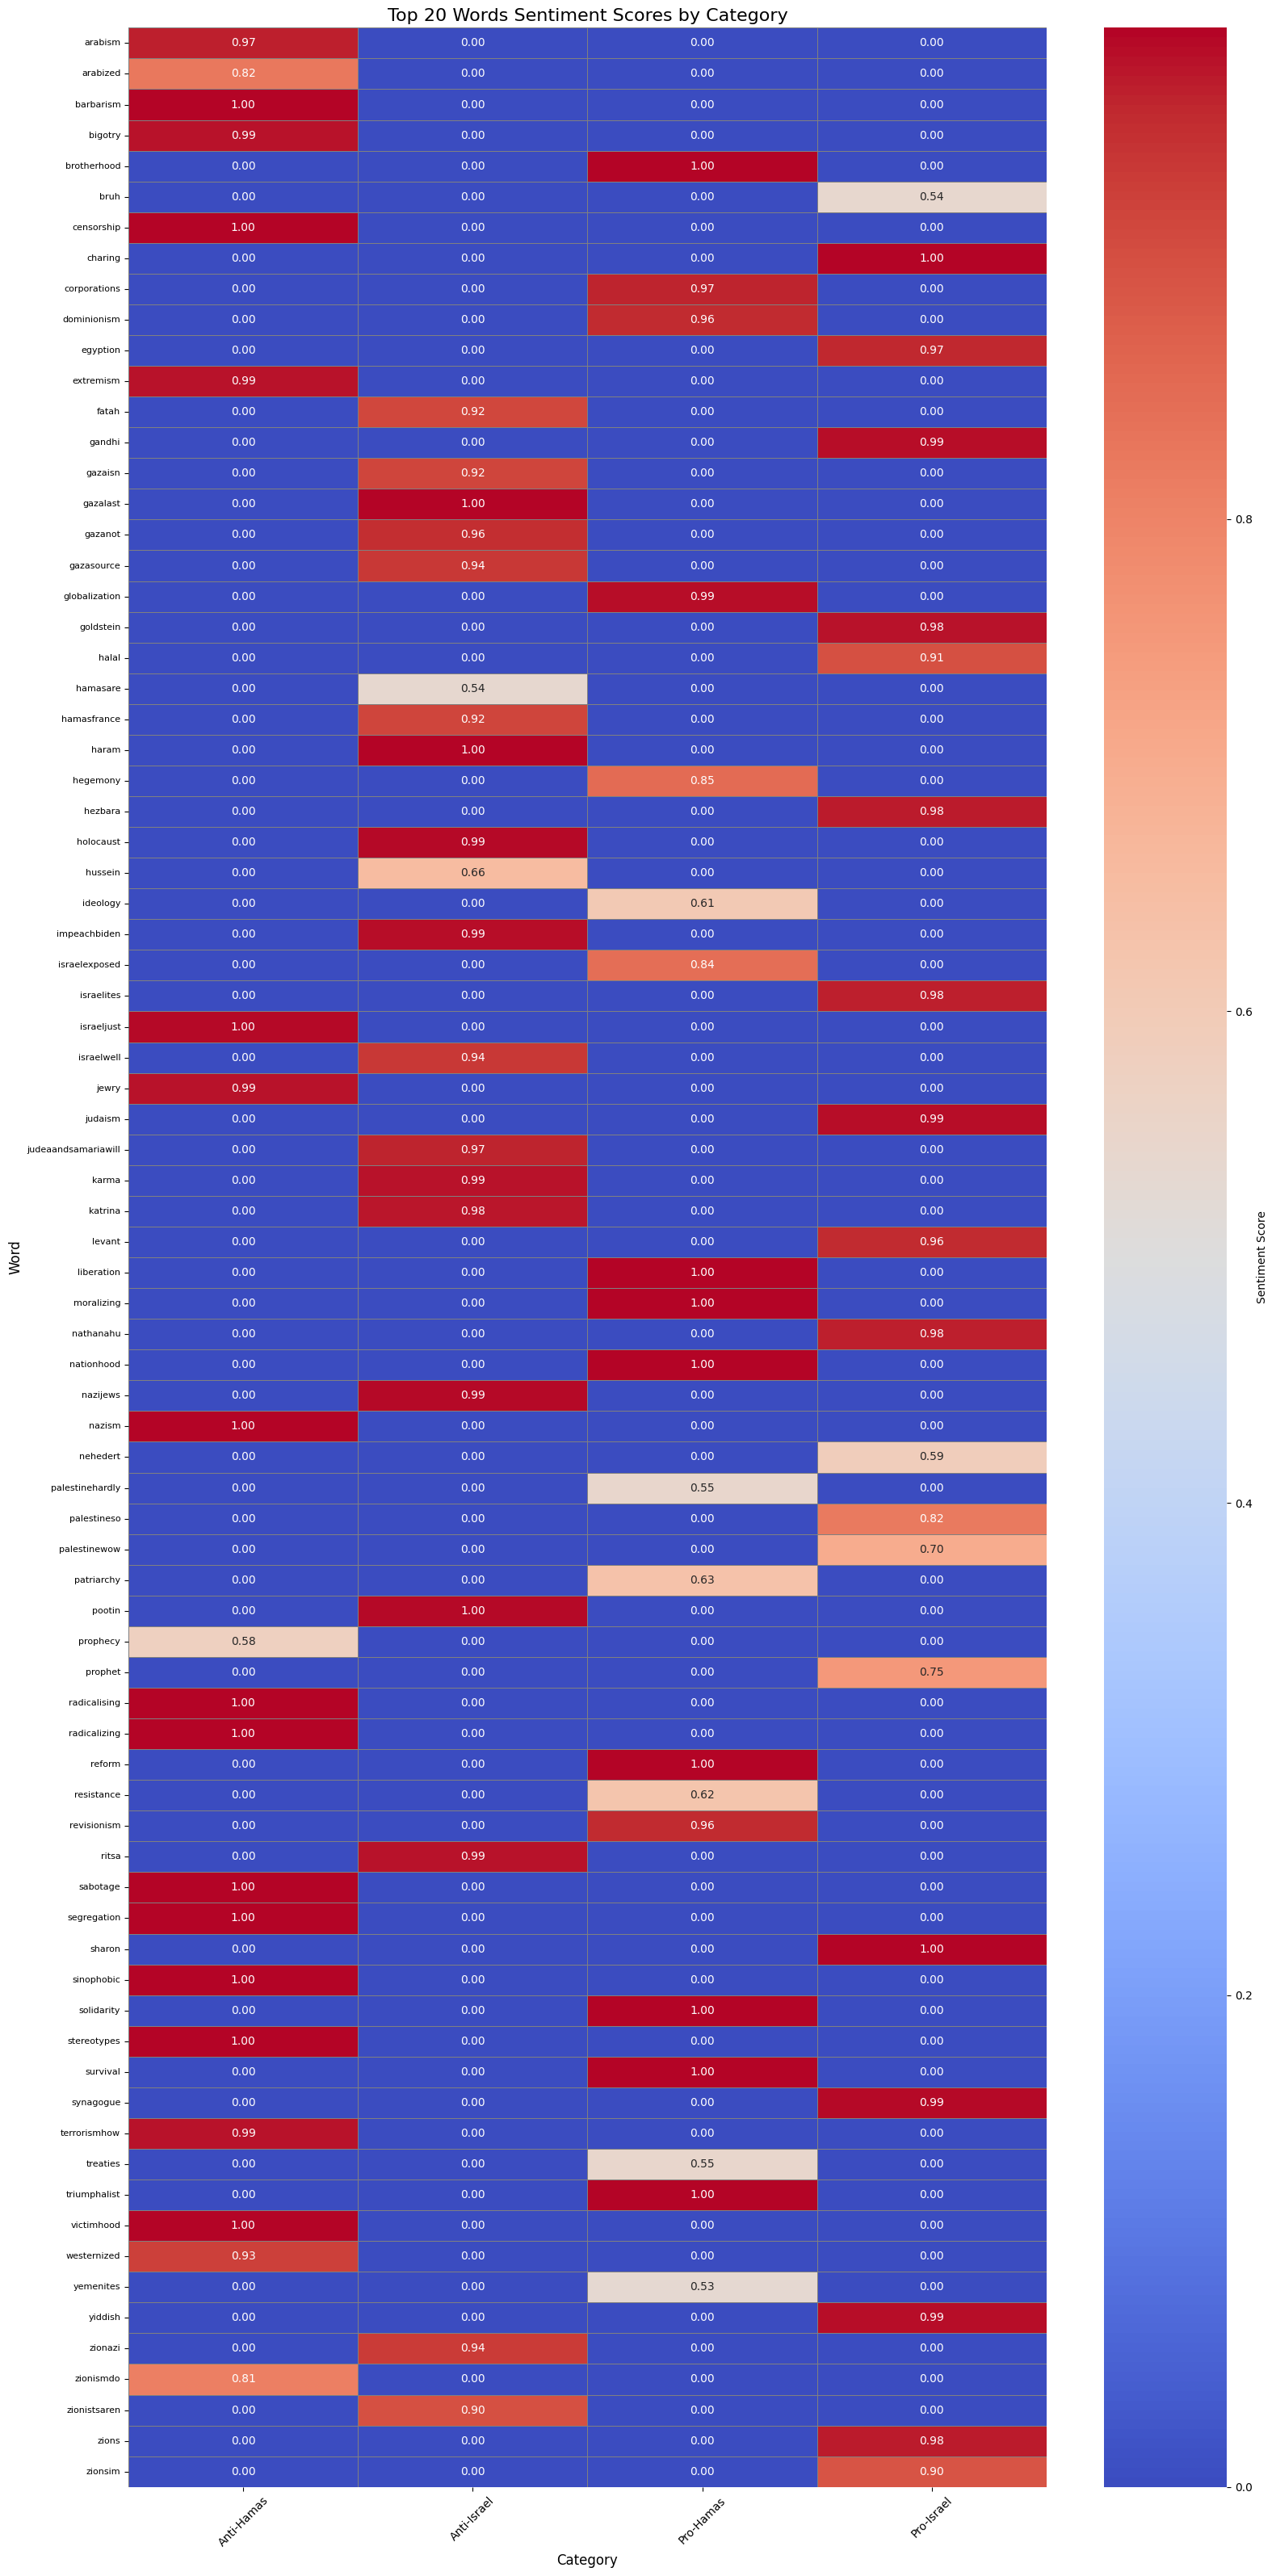

In [57]:
N = 20

# Prepare data for the heatmap
filtered_data_focused = []
for category, words in categories.items():
    # Sort and select the top N words by sentiment score
    top_words = sorted(words, key=lambda x: (x[1], x[2]), reverse=True)[:N]
    for word, similarity, score in top_words:
        filtered_data_focused.append({"Category": category, "Word": word, "Score": score})

# Convert filtered data into a pandas DataFrame
focused_df = pd.DataFrame(filtered_data_focused)

# Pivot the DataFrame to create a matrix for the heatmap
focused_pivot = focused_df.pivot(index="Word", columns="Category", values="Score").fillna(0)

# Set figure size dynamically based on the data
plt.figure(figsize=(16, max(10, len(focused_pivot)) * 0.4))

# Create the heatmap
sns.heatmap(
    focused_pivot,
    cmap="coolwarm",        # Color scheme for sentiment scores
    annot=True,             # Show sentiment scores on the heatmap
    fmt=".2f",              # Format for sentiment scores
    cbar_kws={'label': 'Sentiment Score'},  # Color bar label
    linewidths=0.5,         # Line width for grid lines
    linecolor='gray'        # Grid line color
)

# Add titles and labels
plt.title("Top 20 Words Sentiment Scores by Category", fontsize=16)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Word", fontsize=12)
plt.xticks(fontsize=10, rotation=45)  # Rotate category labels for better readability
plt.yticks(fontsize=8)
plt.tight_layout()  # Adjust layout to prevent overlapping elements

# Show the heatmap
plt.show()